This notebook implements a search-based procedure to solve a k-means clustering task. The following code block imports libraries we will use.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.datasets
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
from tqdm.auto import tqdm

sns.set_style('whitegrid')

The following code block uses `scikit-learn` to generate sample data.

In [2]:
coordinates, cluster, actual_centers = sklearn.datasets.make_blobs(
    n_samples=1000,
    centers=5,
    cluster_std=1.0,
    random_state=42,
    return_centers=True,
)

coordinates = pd.DataFrame(
    coordinates,
    columns=['d1', 'd2'],
)

The following code block defines a function to plot the clustering data along with cluster centers.

In [3]:
def plot_clustering(
    coordinates_df: pd.DataFrame,
    cluster_label_array: np.ndarray,
    centers_array: np.ndarray,
) -> None:
    

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    sns.scatterplot(
        data=coordinates_df,
        x='d1',
        y='d2',
        c=cluster_label_array,
        edgecolor='k',
        ax=ax,
    )
    
    sns.scatterplot(
        x=centers_array[:, 0],
        y=centers_array[:, 1],
        marker='*',
        s=500,
        color='yellow',
        edgecolor='k',
        ax=ax,
    )
    
    plt.show()

The following code block uses the `plot_clustering` function to plot the sample data and the centroids of the bivariate Normal distributions used to generate the data.

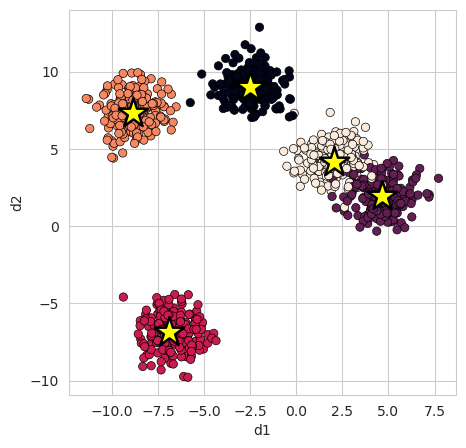

In [4]:
plot_clustering(
    coordinates_df=coordinates,
    cluster_label_array=cluster,
    centers_array=actual_centers,
)

#### Procedure Pseudocode

An outline of the procedure we will implement follows:

- Specify `k`
- Specify `max_iterations`
- Initialize cluster centers
- Assign points to the closest cluster
- Set `best_WCSS` to Within-Cluster Residual Sum of Squares Error (WCSS) for initial assignments
- Set `best_centers` to initial cluster centers
- Set `best_cluster_assignments` to initial cluster assignments
- Initialize `iteration = 0`
- Initialize `IMPROVING = True`
- **while** (`iteration < max_iterations`) and (`IMPROVING == True`):
  - `iteration += 1`
  - `IMPROVING = False`
  - Update cluster centers according to the centroids of assigned points
  - Assign points to the closest cluster center
  - Set `candidate_WCSS` to WCSS for updated assignments
  - **if** `candidate_WCSS` < `best_WCSS`:
    - Set `best_WCSS=candidate_WCSS`
    - Set `best_centers` to updated cluster centers
    - Set `best_cluster_assignments` to updated cluster assignments
    - `IMPROVING = True`
      
**return** `best_centers`, `best_WCSS`, `best_cluster_assignments`

The following code block defines a function to initailize the cluster centers

In [5]:
def initialize_cluster_centers(
    K: int,
    coordinates_df: pd.DataFrame,
    random_seed: int = 42,
) -> np.array:

    np.random.seed(random_seed)
    selected_index_values = np.random.choice(
        coordinates.index,
        size=K,
        replace=False,
    )
    selected_coordinates = coordinates.loc[selected_index_values, :]
    assert selected_coordinates.shape[0] == K

    return selected_coordinates.values

The following code block demonstrates the use of the `initialize_cluster_centers` function

In [6]:
initial_cluster_centers = initialize_cluster_centers(
    K=5,
    coordinates_df=coordinates,
)

initial_cluster_centers

array([[-3.26833028,  9.16467991],
       [ 3.94015333,  2.18714959],
       [ 3.66400558,  3.02681148],
       [-7.51858894, -8.20319939],
       [-2.06537819,  9.78892018]])

The following code block defines a function to compute the distance between each point and a set of cluster centers

In [7]:
def compute_point_to_cluster_distances(
    coordinates_df: pd.DataFrame,
    cluster_centers: np.ndarray,
) -> np.array:

    distance_matrix = euclidean_distances(
        coordinates_df.values,
        cluster_centers,
    )
    assert distance_matrix.shape[0] == coordinates_df.shape[0]
    assert distance_matrix.shape[1] == cluster_centers.shape[0]

    return distance_matrix

The following code block demonstrates the use of the `compute_point_to_cluster_distances` function

In [8]:
initial_cluster_centers = initialize_cluster_centers(
    K=5,
    coordinates_df=coordinates,
)

initial_cluster_distances = compute_point_to_cluster_distances(
    coordinates_df=coordinates,
    cluster_centers=initial_cluster_centers,
)

initial_cluster_distances

array([[10.58330087,  1.15044802,  1.426614  , 16.54014903, 10.10534858],
       [10.28441727,  1.21845056,  1.88163544, 14.27991049, 10.09532083],
       [19.10553105, 15.58686244, 16.06837109,  2.07773176, 19.93182995],
       ...,
       [ 6.50381767, 14.27357505, 13.74083176, 15.46059411,  7.84447581],
       [ 9.5588543 ,  1.6927983 ,  1.18303886, 17.02097571,  9.00188321],
       [ 4.71429757, 13.07618652, 12.47619144, 16.12196083,  6.04626706]])

The following code block shows how we can assign points to cluster centers using the distances returned by the `compute_point_to_cluster_distances` formula

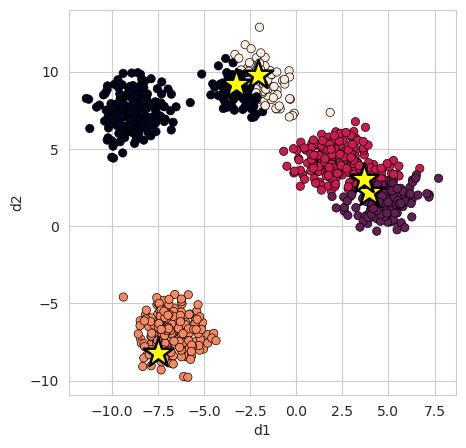

In [9]:
initial_cluster_centers = initialize_cluster_centers(
    K=5,
    coordinates_df=coordinates,
)

initial_cluster_distances = compute_point_to_cluster_distances(
    coordinates_df=coordinates,
    cluster_centers=initial_cluster_centers,
)

initial_cluster_assignments = initial_cluster_distances.argmin(axis=1)

plot_clustering(
    coordinates_df=coordinates,
    cluster_label_array=initial_cluster_assignments,
    centers_array=initial_cluster_centers,
)

The following code block defines a function to compute the Within-Cluster Sum of Squares for a given cluster assignment

In [10]:
def compute_WCSS(
    distance_matrix: np.ndarray,
) -> float:

    minimum_distances = distance_matrix.min(axis=1)
    WCSS = np.sum(np.power(minimum_distances, 2))

    return WCSS 

The following code block demonstrates the use of the `compute_WCSS` formula

In [11]:
initial_cluster_centers = initialize_cluster_centers(
    K=5,
    coordinates_df=coordinates,
)

initial_cluster_distances = compute_point_to_cluster_distances(
    coordinates_df=coordinates,
    cluster_centers=initial_cluster_centers,
)

initial_cluster_assignments = initial_cluster_distances.argmin(axis=1)

compute_WCSS(initial_cluster_distances)

10079.500798380708

The following code block defines a function to update the cluster centers

In [12]:
def update_cluster_centers(
    coordinates_df: pd.DataFrame,
    cluster_label_array: np.ndarray,
) -> np.ndarray:
    

    updated_cluster_centers = coordinates_df.copy()
    updated_cluster_centers['assigned_center'] = cluster_label_array
    
    updated_cluster_centers = updated_cluster_centers.groupby(
        'assigned_center',
    ).mean().values

    return updated_cluster_centers

The following code block demonstrates the use of the `update_cluster_centers` formula

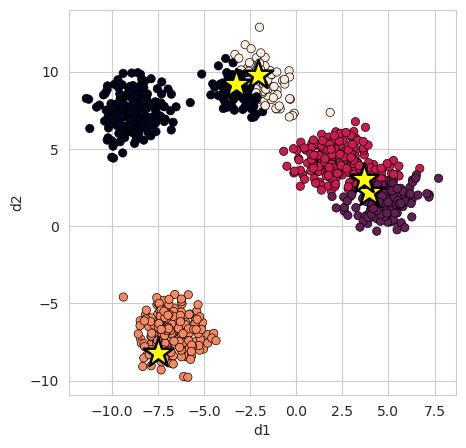

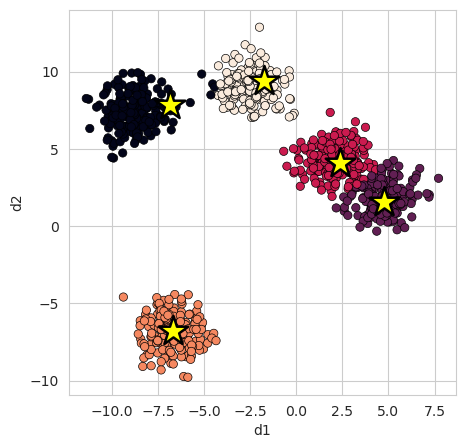

In [13]:
initial_cluster_centers = initialize_cluster_centers(
    K=5,
    coordinates_df=coordinates,
)

initial_cluster_distances = compute_point_to_cluster_distances(
    coordinates_df=coordinates,
    cluster_centers=initial_cluster_centers,
)

initial_cluster_assignments = initial_cluster_distances.argmin(axis=1)

initial_WCSS = compute_WCSS(initial_cluster_distances)

plot_clustering(
    coordinates_df=coordinates,
    cluster_label_array=initial_cluster_assignments,
    centers_array=initial_cluster_centers,
)

updated_cluster_centers = update_cluster_centers(
    coordinates_df=coordinates,
    cluster_label_array=initial_cluster_assignments,
)

updated_cluster_distances = compute_point_to_cluster_distances(
    coordinates_df=coordinates,
    cluster_centers=updated_cluster_centers,
)

updated_cluster_assignments = updated_cluster_distances.argmin(axis=1)

updated_WCSS = compute_WCSS(updated_cluster_distances)

plot_clustering(
    coordinates_df=coordinates,
    cluster_label_array=updated_cluster_assignments,
    centers_array=updated_cluster_centers,
)

The following code block implements the complete procedure for a fixed value of K

In [14]:
K = 5
max_iterations = 100

initial_cluster_centers = initialize_cluster_centers(
    K=K,
    coordinates_df=coordinates,
)

initial_cluster_distances = compute_point_to_cluster_distances(
    coordinates_df=coordinates,
    cluster_centers=initial_cluster_centers,
)
initial_cluster_assignments = initial_cluster_distances.argmin(axis=1)

best_WCSS = compute_WCSS(initial_cluster_distances)
best_centers = initial_cluster_centers
best_cluster_assignments = initial_cluster_assignments

iteration = 0
IMPROVING = True

while (iteration < max_iterations) and (IMPROVING == True):
    iteration += 1
    IMPROVING = False

    updated_cluster_centers = update_cluster_centers(
        coordinates_df=coordinates,
        cluster_label_array=best_cluster_assignments,
    )
    
    updated_cluster_distances = compute_point_to_cluster_distances(
        coordinates_df=coordinates,
        cluster_centers=updated_cluster_centers,
    )
    
    updated_cluster_assignments = updated_cluster_distances.argmin(axis=1)
    candidate_WCSS = compute_WCSS(updated_cluster_distances)

    if candidate_WCSS < best_WCSS:
        best_WCSS = candidate_WCSS
        best_centers = updated_cluster_centers
        best_cluster_assignments = updated_cluster_assignments
        IMPROVING = True

The following code block plots the clustering identifed by the procedure

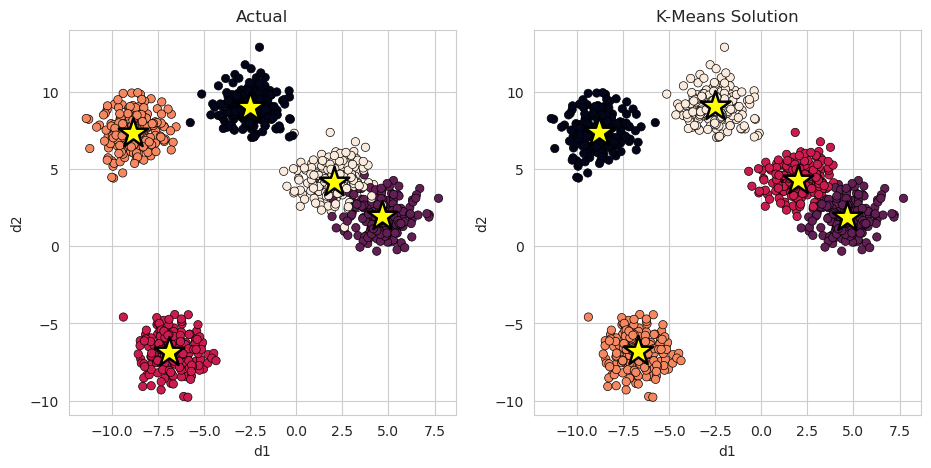

In [15]:
fig, ax  = plt.subplots(1, 2, figsize=(11, 5))

sns.scatterplot(
    x='d1',
    y='d2',
    data=coordinates,
    c=cluster,
    edgecolor='k',
    ax=ax[0],
)

sns.scatterplot(
    x=actual_centers[:, 0],
    y=actual_centers[:, 1],
    marker='*',
    s=500,
    color='yellow',
    edgecolor='k',
    ax=ax[0],
)
ax[0].set_title('Actual')

sns.scatterplot(
    x='d1',
    y='d2',
    data=coordinates,
    c=best_cluster_assignments,
    edgecolor='k',
    ax=ax[1],
)
sns.scatterplot(
    x=best_centers[:, 0],
    y=best_centers[:, 1],
    marker='*',
    s=500,
    color='yellow',
    edgecolor='k',
    ax=ax[1],
)
ax[1].set_title('K-Means Solution')

plt.show()

The following code block varies K between 2 and 15, determining a clustering solution for each value of K

In [16]:
K_experiment = []

for K in tqdm(range(2, 16)):
    max_iterations = 100
    
    initial_cluster_centers = initialize_cluster_centers(
        K=K,
        coordinates_df=coordinates,
    )
    
    initial_cluster_distances = compute_point_to_cluster_distances(
        coordinates_df=coordinates,
        cluster_centers=initial_cluster_centers,
    )
    initial_cluster_assignments = initial_cluster_distances.argmin(axis=1)
    
    best_WCSS = compute_WCSS(initial_cluster_distances)
    best_centers = initial_cluster_centers
    best_cluster_assignments = initial_cluster_assignments
    
    iteration = 0
    IMPROVING = True
    
    while (iteration < max_iterations) and (IMPROVING == True):
        iteration += 1
        IMPROVING = False
    
        updated_cluster_centers = update_cluster_centers(
            coordinates_df=coordinates,
            cluster_label_array=best_cluster_assignments,
        )
        
        updated_cluster_distances = compute_point_to_cluster_distances(
            coordinates_df=coordinates,
            cluster_centers=updated_cluster_centers,
        )
        
        updated_cluster_assignments = updated_cluster_distances.argmin(axis=1)
        candidate_WCSS = compute_WCSS(updated_cluster_distances)
    
        if candidate_WCSS < best_WCSS:
            best_WCSS = candidate_WCSS
            best_centers = updated_cluster_centers
            best_cluster_assignments = updated_cluster_assignments
            IMPROVING = True
    
    K_experiment.append({'K': K, 'WCSS': best_WCSS})

K_experiment = pd.DataFrame(K_experiment)

  0%|          | 0/14 [00:00<?, ?it/s]

The following code block shows how WCSS varies as K increases. It also plots a vertical line corresponding to K=5.

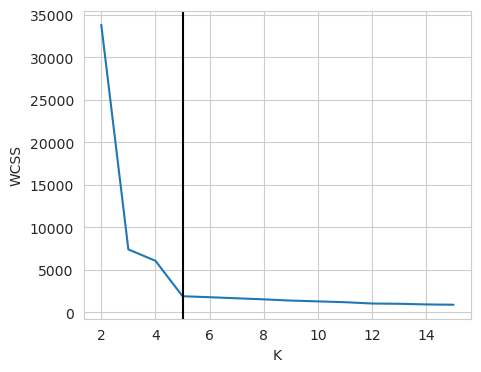

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

sns.lineplot(
    data=K_experiment,
    x='K',
    y='WCSS',
)
ax.axvline(5, color='k')

plt.show()

#### Things to think about
- What happens if the data becomes more or less concentrated around cluster centers?